# Exercise 14 - Physics-Informed Neural Network for a Static Bar
### Task
Implement a physics-informed neural network for a one-dimensional static bar
1. Analytically determine, then define the distributed load `distLoad` according to the exercise description
2. implement the prediction of the displacements (without strong enforcement) as `getDisplacements`
3. implement the physics-informed and boundary loss computation as `getLossTerms`
4. compute the cost function with `getCostFunction`
5. Train the physics-informed neural network by executing the training loop
6. Improve the convergence by adjusting the hyperparameters
7. Reproduce the example from Section 4.2.1. by replacing the problem parameters

### Learning goals
- Understand how physics-informed neural networks work and how they are implemented
- Gain an intuition about the performance of physics-informed neural networks and how the hyperparameters affect the convergence 

**import libraries & set seed**

In [5]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

In [6]:
torch.manual_seed(2)

## Utilities

**gradient computation with automatic differentiation**

In [7]:
def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(
            y, x, torch.ones(x.size()[0], 1), create_graph=True, retain_graph=True
        )[0]
        return getDerivative(dy_dx, x, n - 1)

**neural network**

In [8]:
class NN(torch.nn.Module):
    def __init__(
        self,
        inputDimension,
        hiddenDimensions,
        outputDimension,
        activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []

        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

**initialization of neural network weights**

In [9]:
def initWeights(m):
    """Initialize weights of neural network with xavier initialization."""
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(
            m.weight, gain=torch.nn.init.calculate_gain("tanh")
        )  # adapt if using a different initialization
        m.bias.data.fill_(0.0)

## PINN helper functions

**displacement computation**
$$\hat{u}=F_{NN}(x)$$

In [10]:
def getDisplacements(model, x):
    return model(x)

**loss term computation**

The differential equation loss
$$\mathcal{L}_R=\sum_{i=1}^N\bigl(\frac{d}{dx}EA\bigl(\frac{d\hat{u}}{dx}\bigr)+p\bigr)^2$$
The boundary condition loss 
$$\mathcal{L}_B=\sum_{i=1}^{N_B}\bigl( \frac{d^{n_i} \hat{u}}{dx^{n_i}} - F \bigr)^2$$

In [11]:
def getLossTerms(x, xB, u, uB, EA, distLoad, uBLabel):
    differentialEquationLoss = (
        getDerivative(EA * getDerivative(u, x, 1), x, 1) + distLoad
    )
    differentialEquationLoss = torch.sum(differentialEquationLoss**2).squeeze()

    # initialization
    boundaryConditionLoss = 0

    for i in range(len(uBLabel)):
        boundaryConditionLoss += (
            getDerivative(uB, xB, uBLabel[i][1])[i] - uBLabel[i][0]
        ).squeeze() ** 2

    return differentialEquationLoss, boundaryConditionLoss

**cost function computation**
$$C=\mathcal{L}_R+\mathcal{L}_B$$

In [12]:
def getCostFunction(lossTerms):
    return lossTerms[0] + lossTerms[1]

## Problem setup

**physical parameters**

In [ ]:
# Prescribed displacement
uAnalytic = lambda x: (1.0 - np.cos(3.0 * np.pi * x))

# Problem data
E = lambda x: 1.0  # Young's modulus
A = lambda x: x**2 + 1.0  # cross-sectional area
L = 3.0 / 2.0  # bar length
uB = [
    [0, 0, 0],
    [0, 1, 0],
]  # boundary conditions: [value, degree of differentiation, coordinate]

# analytic solution for distributed load p(x)
distLoad = lambda x: -6 * x * np.pi * torch.sin(3 * np.pi * x) - 9 * (
    x**2 + 1) * np.pi**2 * torch.cos( 3 * np.pi * x)  

**hyperparameters**

currently Adam is selected as optimizer. By commenting the Adam block and uncommenting the LBFGS block, you can enable LBFGS as optimizer.

In [14]:
Nx = 100  # number of collocation points
hiddenDimensions = [100]  # definition of hidden layers
activationFunction = (
    torch.nn.Tanh()
)  # if this is changed, also adapt the initialization

epochs = 5000  # number of epochs
lr = 5e-3  # learning rate
selectOptimizer = "Adam"

# epochs = 500
# selectOptimizer = "LBFGS"
# lr = 1e-2

**neural network & optimizer setup**

In [15]:
model = NN(1, hiddenDimensions, 1, activationFunction)
model.apply(initWeights)
if selectOptimizer == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr)
elif selectOptimizer == "LBFGS":
    optimizer = torch.optim.LBFGS(model.parameters(), lr)

**training grid**

In [16]:
x = torch.linspace(0, L, Nx, requires_grad=True).unsqueeze(1)

# boundary points
xB = torch.tensor([uBi[2] for uBi in uB]).unsqueeze(1).to(torch.float32)
xB.requires_grad = True

## Training

In [17]:
differentialEquationLossHistory = np.zeros(epochs)
boundaryConditionLossHistory = np.zeros(epochs)
costHistory = np.zeros(epochs)

start = time.perf_counter()
start0 = start
for epoch in range(epochs):
    # predict displacements
    uPred = getDisplacements(model, x)
    uBPred = getDisplacements(model, xB)

    lossTerms = getLossTerms(x, xB, uPred, uBPred, E(x) * A(x), distLoad(x), uB)
    differentialEquationLossHistory[epoch] = lossTerms[0].detach()
    boundaryConditionLossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = getCostFunction(lossTerms).detach()

    def closure():
        optimizer.zero_grad()
        uPred = getDisplacements(model, x)
        uBPred = getDisplacements(model, xB)
        lossTerms = getLossTerms(x, xB, uPred, uBPred, E(x) * A(x), distLoad(x), uB)
        cost = getCostFunction(lossTerms)
        cost.backward(retain_graph=True)
        return cost

    optimizer.step(closure)

    if epoch % 100 == 0:
        elapsedTime = (time.perf_counter() - start) / 100
        string = "Epoch: {}/{}\t\tDifferential equation loss = {:2e}\t\tBoundary condition closs = {:2e}\nCost = {:2e}\t\tElapsed time = {:2f}"
        # Format string and print
        print(
            string.format(
                epoch,
                epochs - 1,
                differentialEquationLossHistory[epoch],
                boundaryConditionLossHistory[epoch],
                costHistory[epoch],
                elapsedTime,
            )
        )
        start = time.perf_counter()
elapsedTime = time.perf_counter() - start0
string = "Total elapsed time: {:2f}\nAverage elapsed time per epoch: {:2f}"
print(string.format(elapsedTime, elapsedTime / epochs))

Epoch: 0/4999		Differential equation loss = 1.403162e+06		Boundary condition closs = 1.358311e-02
Cost = 1.403162e+06		Elapsed time = 0.000662
Epoch: 100/4999		Differential equation loss = 1.290646e+06		Boundary condition closs = 6.186681e+02
Cost = 1.291265e+06		Elapsed time = 0.004353
Epoch: 200/4999		Differential equation loss = 1.179141e+06		Boundary condition closs = 1.479357e+03
Cost = 1.180620e+06		Elapsed time = 0.004188
Epoch: 300/4999		Differential equation loss = 9.098866e+05		Boundary condition closs = 1.539529e+03
Cost = 9.114261e+05		Elapsed time = 0.003749
Epoch: 400/4999		Differential equation loss = 6.080709e+05		Boundary condition closs = 1.429764e+03
Cost = 6.095006e+05		Elapsed time = 0.003696
Epoch: 500/4999		Differential equation loss = 1.809981e+05		Boundary condition closs = 5.228785e+02
Cost = 1.815210e+05		Elapsed time = 0.004226
Epoch: 600/4999		Differential equation loss = 1.004079e+05		Boundary condition closs = 2.762376e+02
Cost = 1.006841e+05		Elapsed tim

## Post-processing

**training history**

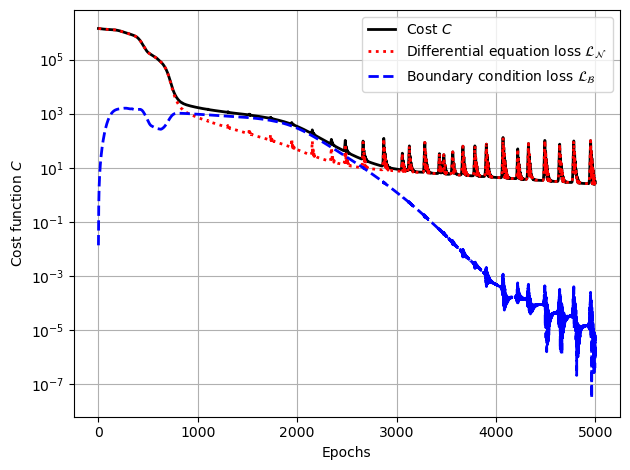

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("Epochs")
ax.set_ylabel("Cost function $C$")
ax.set_yscale("log")

ax.plot(costHistory, "k", linewidth=2, label="Cost $C$")
ax.plot(
    differentialEquationLossHistory,
    "r:",
    linewidth=2,
    label="Differential equation loss $\\mathcal{L}_{\\mathcal{N}}$",
)
ax.plot(
    boundaryConditionLossHistory,
    "b--",
    linewidth=2,
    label="Boundary condition loss $\\mathcal{L}_{\\mathcal{B}}$",
)

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()

**displacement prediction**

/tmp/xpython_2030/3660899926.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  uAnalytic = lambda x: (1.0 - np.cos(3.0 * np.pi * x))


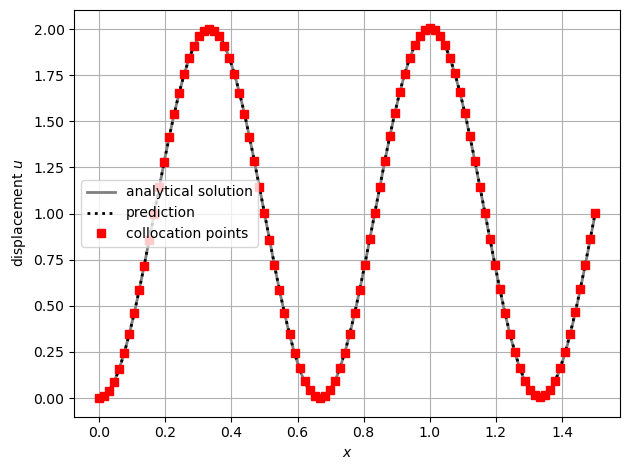

In [19]:
xTest = torch.linspace(0, L, 1000).unsqueeze(1)
uPredTest = getDisplacements(model, xTest).detach()
uPred = getDisplacements(model, x).detach()

fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("displacement $u$")

ax.plot(xTest, uAnalytic(xTest), "gray", linewidth=2, label="analytical solution")
ax.plot(xTest, uPredTest, "k:", linewidth=2, label="prediction")
ax.plot(x.detach(), uPred, "rs", markersize=6, label="collocation points")

ax.grid()
ax.legend()
fig.tight_layout()
plt.show()